In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3, CP_L3_sparse, NCP_L3, CP, Chebyshev, Chebyshev_L3
import polynomial_nets as pn
import poly_utils as ut 

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, VAE_CP_L3_sparse, VAE_CP_L3_sparse_LU, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

import uqtestfuns as uqtf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from Cuda import DeviceDataLoader

/home/ashish-razer/Programs/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CP_sparse_degree(nn.Module):
    def __init__(self, degree, d, k, o):
        super(CP_sparse_degree, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        masks = ut.generate_masks(self.degree, self.rank, self.input_dimension)
        for i in range(1, self.degree + 1):
            setattr(self, 'U{}'.format(i), nn.Parameter(nn.Linear(d, k, bias=False).weight * masks[i-1]))
            self.register_buffer('mask{}'.format(i), masks[i-1])        

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out = torch.matmul(z, (self.mask1 * self.U1).T)
        for i in range(2, self.degree + 1):
            #out = getattr(self, 'U{}'.format(i))(z) * out + out
            out = torch.matmul(z, (getattr(self, 'mask{}'.format(i)) * getattr(self, 'U{}'.format(i))).T) * out + out
        x = self.layer_C(out)
        return x

In [3]:
nn.Linear(3, 10, bias=False).weight 

Parameter containing:
tensor([[ 0.3666, -0.0555, -0.2127],
        [ 0.3478,  0.0448, -0.3724],
        [-0.3322, -0.3740,  0.1684],
        [ 0.1120, -0.3395,  0.3892],
        [-0.0437,  0.1424, -0.5610],
        [-0.2138, -0.2983, -0.2859],
        [-0.2825,  0.4867,  0.1054],
        [-0.2678,  0.0427, -0.3063],
        [-0.1818,  0.4596,  0.4368],
        [ 0.2023, -0.0191, -0.0732]], requires_grad=True)

In [4]:
class CP_L3(nn.Module):
    def __init__(self, d, k, o):
        super(CP_L3, self).__init__()
        
        self.layer_U1 = nn.Linear(d, k, bias=False)
        self.layer_U2 = nn.Linear(d, k, bias=False)
        self.layer_U3 = nn.Linear(d, k, bias=False)
        self.layer_C = nn.Linear(k, o)   
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        x1 = self.layer_U1(z)
        x2 = self.layer_U2(z) * x1 + x1 
        x3 = self.layer_U3(z) * x2 + x2 
        x = self.layer_C(x3)
        return x

In [5]:
class CP_L3_sparse_U(nn.Module):
    def __init__(self, d, k, o):
        super(CP_L3_sparse_U, self).__init__()
        
        #self.layer_U1 = nn.Linear(d, k, bias=False) 
        self.layer_U1 = nn.Parameter(torch.triu(nn.Linear(d, k, bias=False).weight))   
        self.layer_U2 = nn.Parameter(torch.triu(nn.Linear(d, k, bias=False).weight)) 
        self.layer_U3 = nn.Parameter(torch.triu(nn.Linear(d, k, bias=False).weight)) 
        nn.Parameter(torch.triu(nn.Linear(d, k, bias=False).weight))
        #self.mask = torch.triu(torch.ones_like(self.layer_U1))
        self.register_buffer('mask', torch.triu(torch.ones_like(self.layer_U2)))
        self.layer_C = nn.Linear(k, o)   
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        #x1 = self.layer_U1(z)
        x1 = torch.matmul(z, (self.mask * self.layer_U1).T)
        x2 = torch.matmul(z, (self.mask * self.layer_U2).T) * x1 + x1
        x3 = torch.matmul(z, (self.mask * self.layer_U3).T) * x2 + x2
        x = self.layer_C(x3)
        return x

In [6]:
class CP_learned_sparsity(nn.Module):
    def __init__(self, degree, d, k, o):
        super(CP_learned_sparsity, self).__init__()       

        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        for i in range(1, self.degree + 1):
            setattr(self, 'U{}'.format(i), nn.Parameter(torch.tril(nn.Linear(d, k, bias=False).weight))) 

        self.register_buffer('mask', torch.tril(torch.ones_like(self.U2)))

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        
        out = torch.matmul(z, (self.mask * self.U1).T)
        for i in range(2, self.degree + 1):
            #out = getattr(self, 'U{}'.format(i))(z) * out + out
            out = torch.matmul(z, (self.mask * getattr(self, 'U{}'.format(i))).T) * out + out
        x = self.layer_C(out)
        return x
         

In [7]:
class CP_sparse_LU(nn.Module):
    def __init__(self, degree, d, k, o):
        super(CP_sparse_LU, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        if self.input_dimension > self.rank:
            self.register_buffer('mask1', torch.triu(torch.ones_like(nn.Linear(d, k, bias=False).weight)))
            self.register_buffer('mask2', torch.tril(torch.ones_like(nn.Linear(d, k, bias=False).weight)))
            for i in range(1, self.degree + 1, 2):
                setattr(self, 'U{}'.format(i), nn.Parameter(torch.triu(nn.Linear(d, k, bias=False).weight))) 
            for i in range(2, self.degree + 1, 2):
                setattr(self, 'U{}'.format(i), nn.Parameter(torch.tril(nn.Linear(d, k, bias=False).weight)))  
        else:
            self.register_buffer('mask1', torch.tril(torch.ones_like(nn.Linear(d, k, bias=False).weight)))
            self.register_buffer('mask2', torch.triu(torch.ones_like(nn.Linear(d, k, bias=False).weight)))

            for i in range(1, self.degree + 1, 2):
                setattr(self, 'U{}'.format(i), nn.Parameter(torch.tril(nn.Linear(d, k, bias=False).weight))) 
            for i in range(2, self.degree + 1, 2):
                setattr(self, 'U{}'.format(i), nn.Parameter(torch.triu(nn.Linear(d, k, bias=False).weight)))         

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out = torch.matmul(z, (self.mask1 * self.U1).T)
        for i in range(2, self.degree + 1):
            #out = getattr(self, 'U{}'.format(i))(z) * out + out
            out = torch.matmul(z, (self.mask2 * getattr(self, 'U{}'.format(i))).T) * out + out
            if i == self.degree:
                x = self.layer_C(out)
                return x
            out = torch.matmul(z, (self.mask1 * getattr(self, 'U{}'.format(i+1))).T) * out + out
        x = self.layer_C(out)
        return x

In [8]:
class CP_sparse_L(nn.Module):
    def __init__(self, degree, d, k, o):
        super(CP_sparse_L, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        for i in range(1, self.degree + 1):
            setattr(self, 'U{}'.format(i), nn.Parameter(torch.tril(nn.Linear(d, k, bias=False).weight))) 

        self.register_buffer('mask', torch.tril(torch.ones_like(self.U2)))

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out = torch.matmul(z, (self.mask * self.U1).T)
        for i in range(2, self.degree + 1):
            #out = getattr(self, 'U{}'.format(i))(z) * out + out
            out = torch.matmul(z, (self.mask * getattr(self, 'U{}'.format(i))).T) * out + out
        x = self.layer_C(out)
        return x

In [9]:
class CP_sparse_L1(nn.Module):
    def __init__(self, degree, d, k, o):
        super(CP_sparse_L1, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.U1 = nn.Linear(d, k, bias=False)
        for i in range(2, self.degree + 1):
            setattr(self, 'U{}'.format(i), nn.Parameter(torch.tril(nn.Linear(d, k, bias=False).weight))) 

        self.register_buffer('mask', torch.tril(torch.ones_like(self.U2)))

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out = self.U1(z)
        for i in range(2, self.degree + 1):
            #out = getattr(self, 'U{}'.format(i))(z) * out + out
            out = torch.matmul(z, (self.mask * getattr(self, 'U{}'.format(i))).T) * out + out
        x = self.layer_C(out)
        return x

In [10]:
class CP_sparse_U(nn.Module):
    def __init__(self, degree, d, k, o):
        super(CP_sparse_U, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        for i in range(1, self.degree + 1):
            setattr(self, 'U{}'.format(i), nn.Parameter(torch.triu(nn.Linear(d, k, bias=False).weight))) 

        self.register_buffer('mask', torch.triu(torch.ones_like(self.U2)))

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out = torch.matmul(z, (self.mask * self.U1).T)
        for i in range(2, self.degree + 1):
            #out = getattr(self, 'U{}'.format(i))(z) * out + out
            out = torch.matmul(z, (self.mask * getattr(self, 'U{}'.format(i))).T) * out + out
        x = self.layer_C(out)
        return x

In [11]:
class CP_sparse_U1(nn.Module):
    def __init__(self, degree, d, k, o):
        super(CP_sparse_U1, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.U1 = nn.Linear(d, k, bias=False)
        for i in range(2, self.degree + 1):
            setattr(self, 'U{}'.format(i), nn.Parameter(torch.triu(nn.Linear(d, k, bias=False).weight))) 

        self.register_buffer('mask', torch.triu(torch.ones_like(self.U2)))

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out = self.U1(z)
        for i in range(2, self.degree + 1):
            #out = getattr(self, 'U{}'.format(i))(z) * out + out
            out = torch.matmul(z, (self.mask * getattr(self, 'U{}'.format(i))).T) * out + out
        x = self.layer_C(out)
        return x

In [12]:
class CP_L3_sparse_L(nn.Module):
    def __init__(self, d, k, o):
        super(CP_L3_sparse_L, self).__init__()
        
        #self.layer_U1 = nn.Linear(d, k, bias=False) 
        self.layer_U1 = nn.Parameter(torch.tril(nn.Linear(d, k, bias=False).weight))   
        self.layer_U2 = nn.Parameter(torch.tril(nn.Linear(d, k, bias=False).weight)) 
        self.layer_U3 = nn.Parameter(torch.tril(nn.Linear(d, k, bias=False).weight)) 
        nn.Parameter(torch.triu(nn.Linear(d, k, bias=False).weight))
        #self.mask = torch.triu(torch.ones_like(self.layer_U1))
        self.register_buffer('mask', torch.tril(torch.ones_like(self.layer_U2)))
        self.layer_C = nn.Linear(k, o)   
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        #x1 = self.layer_U1(z)
        x1 = torch.matmul(z, (self.mask * self.layer_U1).T)
        x2 = torch.matmul(z, (self.mask * self.layer_U2).T) * x1 + x1
        x3 = torch.matmul(z, (self.mask * self.layer_U3).T) * x2 + x2
        x = self.layer_C(x3)
        return x

In [13]:
class CP_L3_shared(nn.Module):
    def __init__(self, d, k, o):
        super(CP_L3_shared, self).__init__()
        
        self.layer_U1 = nn.Linear(d, k, bias=False)
        #self.layer_U2 = nn.Linear(d, k, bias=False)
        #self.layer_U3 = nn.Linear(d, k, bias=False)
        self.layer_C = nn.Linear(k, o)   
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        x1 = self.layer_U1(z)
        x2 = self.layer_U1(z) * x1 + x1 
        x3 = self.layer_U1(z) * x2 + x2 
        x = self.layer_C(x3)
        return x

In [14]:
class Chebyshev_L3_shared(nn.Module):
    def __init__(self, d, k, o):
        super(Chebyshev_L3_shared, self).__init__()
        
        self.layer_T0 = torch.nn.Parameter(torch.randn(k))
        self.layer_T1 = nn.Linear(d, k, bias=False)
        #self.layer_c = nn.Linear(d, k, bias=False)
        #self.layer_d = nn.Linear(d, k, bias=False)

        self.layer_C = nn.Linear(k, o, bias = False)   
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        x0 = self.layer_T0 
        x1 = self.layer_T1(z)
        x2 = 2 * self.layer_T1(z) * x1 - x0
        x3 = 2 * self.layer_T1(z) * x2 - x1
        x4 = 2 * self.layer_T1(z) * x3 - x2
        x5 = 2 * self.layer_T1(z) * x4 - x3

        #T4 = 2 * self.layer_b(z) * T3 - T2
        #T5 = 2 * self.layer_b(z) * T4 - T3
        
        x = self.layer_C(x3)
        return x

In [15]:
class Chebyshev(nn.Module):
    def __init__(self, degree, d, k, o):
        super(Chebyshev, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.T0 = nn.Parameter(nn.Linear(k, 1).weight.to(torch.float32)[0])
        for i in range(1, self.degree + 1):
            setattr(self, 'T{}'.format(i), nn.Linear(self.input_dimension, self.rank, bias=False)) 

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out0 = self.T0
        out1 = self.T1(z)
        out_list = [out0] + [out1]
        for i in range(2, self.degree + 1, 2):
            out0 = getattr(self, 'T{}'.format(i))(z) * 2 * out1 - out0
            out_list = out_list + [out0]
            if i == self.degree:
                x = self.layer_C(out_list[self.degree])
                return x
            else:
                out1 = getattr(self, 'T{}'.format(i + 1))(z) * 2 * out0 - out1
                out_list = out_list + [out1]
        x = self.layer_C(out_list[self.degree])
        return x


In [16]:
class CP_shared(nn.Module):
    def __init__(self, degree, d, k, o):
        super(CP_shared, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.layer_U1 = nn.Linear(self.input_dimension, self.rank, bias=False)
        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out = self.layer_U1(z)
        for i in range(1, self.degree):
            out = self.layer_U1(z) * out + out
        x = self.layer_C(out)
        return x

In [17]:
#extend the CP_shared model such that for a given degree input int(degree/3) U layers are constructed.
#In the forward pass, the U layers are used in a chain of multiplications and additions such that degree multiplications and degree additions are performed.


In [18]:
class CP_shared2(nn.Module):
    def __init__(self, degree, d, k, o):
        super(CP_shared2, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.divisor = float(degree**-self.degree)
        self.layer_U1 = nn.Linear(self.input_dimension, self.rank, bias=False)
        self.register_buffer('my_buffer',torch.ones_like(self.layer_U1.weight))
        self.layer_C = nn.Linear(self.rank, self.output_dimension) 

    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out = self.layer_U1(z)
        for i in range(1, self.degree):
            out = torch.matmul(z, self.my_buffer.T)* out + out
        x = self.layer_C(out)
        return x

In [19]:
my_testfun =  uqtf.Borehole()
my_testfun =  uqtf.Flood()
my_testfun =  uqtf.DampedOscillator()

N = 10000
train = 0.9
N_t = int(N * train)
N_v = N - N_t

In [20]:
uqtf.list_functions()

 No.      Constructor       Spatial Dimension          Application          Description
-----  ------------------  -------------------  --------------------------  ----------------------------------------------------------------------------
  1         Ackley()                M           optimization, metamodeling  Ackley function from Ackley (1987)
  2        Borehole()               8           metamodeling, sensitivity   Borehole function from Harper and Gupta (1983)
  3    DampedOscillator()           8           metamodeling, sensitivity   Damped oscillator model from Igusa and Der Kiureghian (1985)
  4         Flood()                 8           metamodeling, sensitivity   Flood model from Iooss and Lemaître (2015)
  5        Ishigami()               3                  sensitivity          Ishigami function from Ishigami and Homma (1991)
  6       OTLCircuit()              6           metamodeling, sensitivity   Output transformerless (OTL) circuit model from Ben-Ari and Steinber

In [21]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
NUM_EPOCHS = 5
RANK = 1
DEGREE = 10
IN_DIM = my_testfun.spatial_dimension
OUT_DIM = 1

loss_fn = nn.MSELoss()

In [22]:
np.random.seed(42)
dataset, target_scaler = ut.generate_dataset_uqtf(my_testfun, N, MinMaxScaler())
train_ds, val_ds = random_split(dataset, [N_t, N_v])
train_loader = DeviceDataLoader(DataLoader(train_ds, BATCH_SIZE, shuffle=True), device)
val_loader = DeviceDataLoader(DataLoader(val_ds, BATCH_SIZE), device)

In [23]:
#model = CP_L3_shared(IN_DIM, RANK, OUT_DIM)
#model = CP_shared2(DEGREE, IN_DIM, RANK, OUT_DIM)
#model = Chebyshev_L3_shared(IN_DIM, RANK, OUT_DIM)

#model = CP_L3_sparse_U(IN_DIM, RANK, OUT_DIM)

#model = pn.CP(DEGREE, IN_DIM, RANK, OUT_DIM)
#model = ut.MLP_model(IN_DIM, OUT_DIM)
#model = nn.Sequential(nn.Linear(IN_DIM, RANK), nn.ReLU(), nn.Linear(RANK, OUT_DIM))
#model = pn.ProdCheby_NL2([IN_DIM, RANK, RANK], [3, 3], 1, nn.ReLU())
#model = CP_L3(IN_DIM, RANK, OUT_DIM)
#model =  Chebyshev_L3(IN_DIM, RANK, OUT_DIM)
#model = Chebyshev(DEGREE, IN_DIM, RANK, OUT_DIM)
model = pn.Chebyshev_norm(DEGREE, IN_DIM, RANK, OUT_DIM)
#model = CP_sparse_degree(DEGREE, IN_DIM, RANK, OUT_DIM)
model = pn.Legendre(DEGREE, IN_DIM, RANK, OUT_DIM)
#model = CP_sparse_LU(DEGREE, IN_DIM, RANK, OUT_DIM)
optimizer = torch.optim.Rprop
#optimizer = torch.optim.Adam
#optimizer = torch.optim.SGD

#model = DeviceDataLoader(model, device)

model_reg = ut.Regression(model, IN_DIM, loss_fn).to(device)


In [24]:
#torch.sum(model_reg.model.T1, dim=0)

In [25]:
torch.ones(RANK)

tensor([1.])

In [26]:
print(model_reg.model.T0)

Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)


In [27]:
num_param =  ut.non_zero_count(model_reg)
print(num_param)

tensor(73)


In [28]:
#model.U2

In [29]:
history, losses = ut.fit(NUM_EPOCHS, LEARNING_RATE, model_reg, train_loader, val_loader, opt_func=optimizer)

Epoch [0], train_loss: 0.0406 val_loss: 0.0465
Epoch [1], train_loss: 0.0513 val_loss: 0.0462
Epoch [2], train_loss: 0.0458 val_loss: 0.0455
Epoch [3], train_loss: 0.0649 val_loss: 0.0454
Epoch [4], train_loss: 0.0450 val_loss: 0.0454


In [30]:
model_reg.to('cpu')

Regression(
  (model): Legendre()
  (loss_function): MSELoss()
)

In [31]:
#model.U1

In [32]:
np.random.seed(44)
test_dataset, target_scaler_test = ut.generate_dataset_uqtf(my_testfun, N, MinMaxScaler())
test_target = test_dataset[:, IN_DIM:].to('cpu')
test_input = test_dataset[:, :IN_DIM].to('cpu')
test_target_scaled = target_scaler.inverse_transform(test_target)

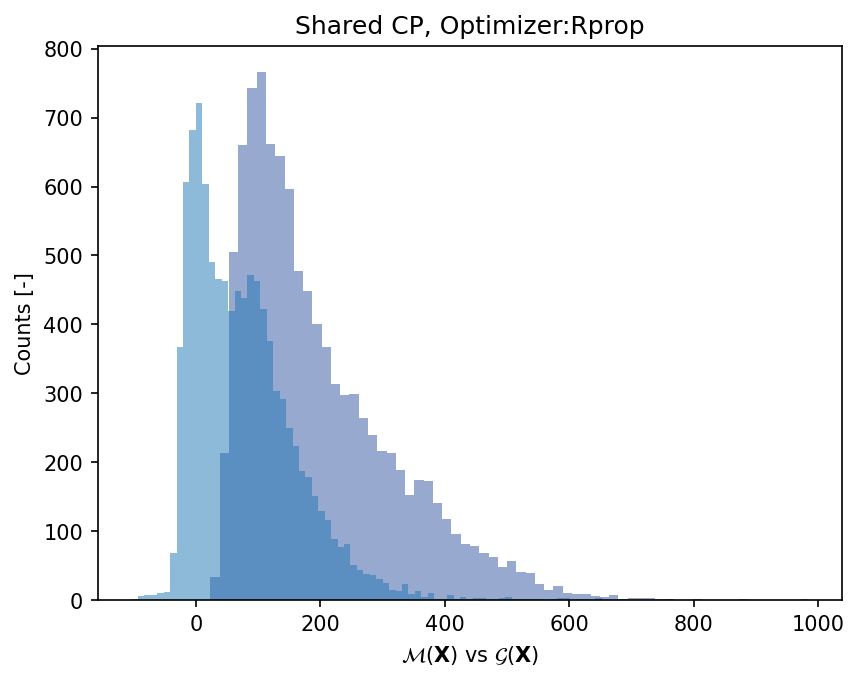

In [33]:
model_name = ['Shared CP']
Optimizer_name = ['Rprop']

outputs = model_reg(test_input).to('cpu')
outputs = target_scaler.inverse_transform(outputs.reshape(-1,1).detach().numpy())
test_target = test_target_scaled



fig1 = plt.figure()
plt.hist(test_target_scaled, bins="auto", color="#8da0cb", alpha = 0.9)
plt.hist(outputs, bins='auto', alpha = 0.5)
#plt.xlim(-300, 300)
#plt.ylim(0, 600)
plt.title(model_name[0] +', Optimizer:'+ Optimizer_name[0])
#plt.title(Optimizer_name[j])
plt.xlabel("$\mathcal{M}(\mathbf{X})$ vs $\mathcal{G}(\mathbf{X})$")
plt.ylabel("Counts [-]")
plt.gcf().set_dpi(150);

In [34]:
np.random.seed(44)


outputs = model_reg(test_dataset[:, :IN_DIM].to('cpu')).to('cpu').detach().numpy()
outputs = torch.tensor(target_scaler.inverse_transform(outputs)) 
test_target = test_dataset[:, IN_DIM:].to('cpu').detach().numpy()
test_target = torch.tensor(target_scaler.inverse_transform(test_target) )
mse = loss_fn(outputs, test_target).detach().item()


l_inf = torch.max(abs(outputs-test_target)).item()


In [35]:
print(mse, l_inf)

35144.73046875 813.206787109375


In [36]:
torch.sum(model_reg.model.T8, dim=1)

tensor([1.0947], grad_fn=<SumBackward1>)

In [40]:
model_reg.model.layer_C

Parameter containing:
tensor([[0.4390]], requires_grad=True)

In [39]:
model(torch.ones(IN_DIM).reshape(1,-1))

tensor([[-4.0652]], grad_fn=<MmBackward0>)

In [38]:
U1_weight = model_reg.model.layer_U1.to(torch.float64)

AttributeError: 'Legendre' object has no attribute 'layer_U1'

In [ ]:
#torch.min(abs(U1_weight))

In [ ]:
num_param =  ut.non_zero_count(model_reg)

In [ ]:
num_param

tensor(185)

In [ ]:
U2_weight = model_reg.model.layer_U2.to(torch.float64)

In [ ]:
model

CP_L3_sparse_U(
  (layer_C): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
mat = torch.randn(3, 9)

In [ ]:
u_mat = torch.triu(mat)
l_mat = torch.tril(mat,)
l_indices = torch.tril_indices(3, 9, offset=-1)

In [ ]:
u_mat

tensor([[ 0.9055,  0.7183, -1.0388,  1.4779, -1.3239,  0.0420,  0.0229,  1.3033,
         -0.0328],
        [ 0.0000,  0.1078, -0.5298,  0.0995, -0.7472, -1.2933, -0.9017,  0.2121,
         -0.3549],
        [ 0.0000,  0.0000, -1.4976,  1.1489, -0.9133,  1.0205, -1.4365, -1.4761,
          0.9422]])

In [ ]:
l_indices

tensor([[1, 2, 2],
        [0, 0, 1]])

In [ ]:
l_indices_r = 8 - l_indices[1] 

In [ ]:
l_indices_r

tensor([8, 8, 7])

In [ ]:
ref_indices = torch.vstack((l_indices[0], l_indices_r))
indices_final = torch.cat((l_indices, ref_indices), dim=1)

In [ ]:
indices_final

tensor([[1, 2, 2, 1, 2, 2],
        [0, 0, 1, 8, 8, 7]])

In [ ]:
ones = torch.ones_like(u_mat)

In [ ]:
ones.index_put_(tuple(indices_final), torch.zeros(len(indices_final[0])))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 1., 1., 0., 0.]])

In [ ]:
#sparse_cheby = ut.sparse_model(copy.deepcopy(Cheby_reg), 0.2)
sparse_params_CP = ut.params_CP(model, k, d)
mi_list_CP = ut.multi_indices_list_CP(sparse_params_CP)
mi_net_CP = ut.multi_indices_net_CP(mi_list_CP)

NameError: name 'k' is not defined

In [ ]:
len(mi_net_CP)

184755

In [ ]:
mi_sum = mi_net_CP.sum(axis=1)
mi_sum_0  = mi_net_CP.sum(axis=0)

In [ ]:

z = torch.randn(2, 3)

In [ ]:
z

tensor([[-0.7503,  0.2244,  0.6072],
        [ 0.9330, -0.3407, -1.8187]])

In [ ]:
#z.repeat_interleave()

In [ ]:
U1 = nn.Linear(d, k, bias=False)

In [ ]:
U1.weight

Parameter containing:
tensor([[-0.1630, -0.2370,  0.1164,  0.2408,  0.2632,  0.1538,  0.1005, -0.0034,
         -0.0961,  0.2502]], requires_grad=True)

In [ ]:
x1 = U1(z)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x3 and 10x1)

In [ ]:
x1

tensor([[-0.0564],
        [ 0.4185]], grad_fn=<MmBackward0>)

In [ ]:
mult_identity = torch.ones_like(U1.weight)

In [ ]:
x1_1 = torch.matmul(z, mult_identity.T)

In [ ]:
x1_1 = U1(z)

In [ ]:
x1_1

tensor([[-0.0564],
        [ 0.4185]], grad_fn=<MmBackward0>)

In [ ]:
x2 = x1 * x1_1

In [ ]:
x3 = x2 * x1_1

In [ ]:
x3

tensor([[-0.0002],
        [ 0.0733]], grad_fn=<MulBackward0>)